<a href="https://colab.research.google.com/github/mr-alamdari/Multi-Classification-Pytorch/blob/main/Multi_Classification_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import torch
import torchvision
import torch.nn as nn
import torchsummary

In [2]:
def plot_history(history, loss=True):

  num_epochs = len(history['train'])
  print(num_epochs)
  title = 'Loss' if loss else 'Accuracy'
  plt.title(f'Train Validation {title}')
  plt.plot(range(1, num_epochs+1), history['train'], label='Train')
  plt.plot(range(1, num_epochs+1), history['val'], label='Validation')
  plt.xlabel('Trainig Epochs')
  plt.ylabel(title)
  plt.legend()
  plt.grid()
  plt.show()

In [3]:
"""STL-10 :::: RGB , (96*96)
Airplane: 0
Bird: 1
Car: 2
Cat: 3
Deer: 4
Dog: 5
Horse:6
Monkey: 7
Ship: 8
Truck: 9"""
path2data = '/content/data'
if not os.path.exists(path2data):
  os.mkdir(path2data)

transformer = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
train_ds = torchvision.datasets.STL10(path2data,
                                      split='train',
                                      download = True,
                                      transform = transformer)
test_ds = torchvision.datasets.STL10(path2data,
                                     split='test',
                                     download=True,
                                     transform = transformer)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting /content/data/stl10_binary.tar.gz to /content/data
Files already downloaded and verified


In [4]:
from sklearn import model_selection
sss = model_selection.StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=43)
indecs = list(range(len(test_ds)))

y_test_ds = [y for _, y in test_ds]

for test_index, val_index in sss.split(indecs, y_test_ds):
  print(f'Test: {test_index}\n Val:{val_index}')
  print(len(test_index), len(val_index))
  val = torch.utils.data.Subset(test_ds, val_index)
  test = torch.utils.data.Subset(test_ds, test_index)
  
y_test = [y for _, y in test]
y_val = [y for _, y in val]

Test: [2720 2206 4570 ... 1454  565 3740]
 Val:[3600 3518   53 ... 6066 3265 3326]
6400 1600


In [5]:
import collections
yr = [t for _, t in train_ds]
train_counter = collections.Counter(yr)
test_counter = collections.Counter(y_test)
val_counter = collections.Counter(y_val)
print(train_counter)
print(test_counter)
print(val_counter)

Counter({1: 500, 5: 500, 6: 500, 3: 500, 9: 500, 7: 500, 4: 500, 8: 500, 0: 500, 2: 500})
Counter({3: 640, 5: 640, 2: 640, 4: 640, 8: 640, 9: 640, 0: 640, 6: 640, 7: 640, 1: 640})
Counter({2: 160, 1: 160, 0: 160, 8: 160, 9: 160, 7: 160, 5: 160, 4: 160, 3: 160, 6: 160})


In [7]:
def show_img(ds, count=24, color=True, rand=True, with_y=True):
  
  rnd = np.random.randint(0, len(ds), count) if rand else len(ds) 
  if with_y:
    x_grid = [ds[i][0] for i in rnd]
    y_gird = [ds[i][1] for i in rnd]
  else:
    x_grid = [ds[i] for i in range(rnd)]

  x_grid = torchvision.utils.make_grid(x_grid, nrows=10, padding=1)
  plt.figure(figsize=(count*4, count*4))
  print(x_grid.shape)
  x_grid = x_grid.numpy().transpose((1, 2, 0))
  plt.imshow(x_grid)
  if with_y:
    plt.title(y_gird)

torch.Size([3, 292, 777])


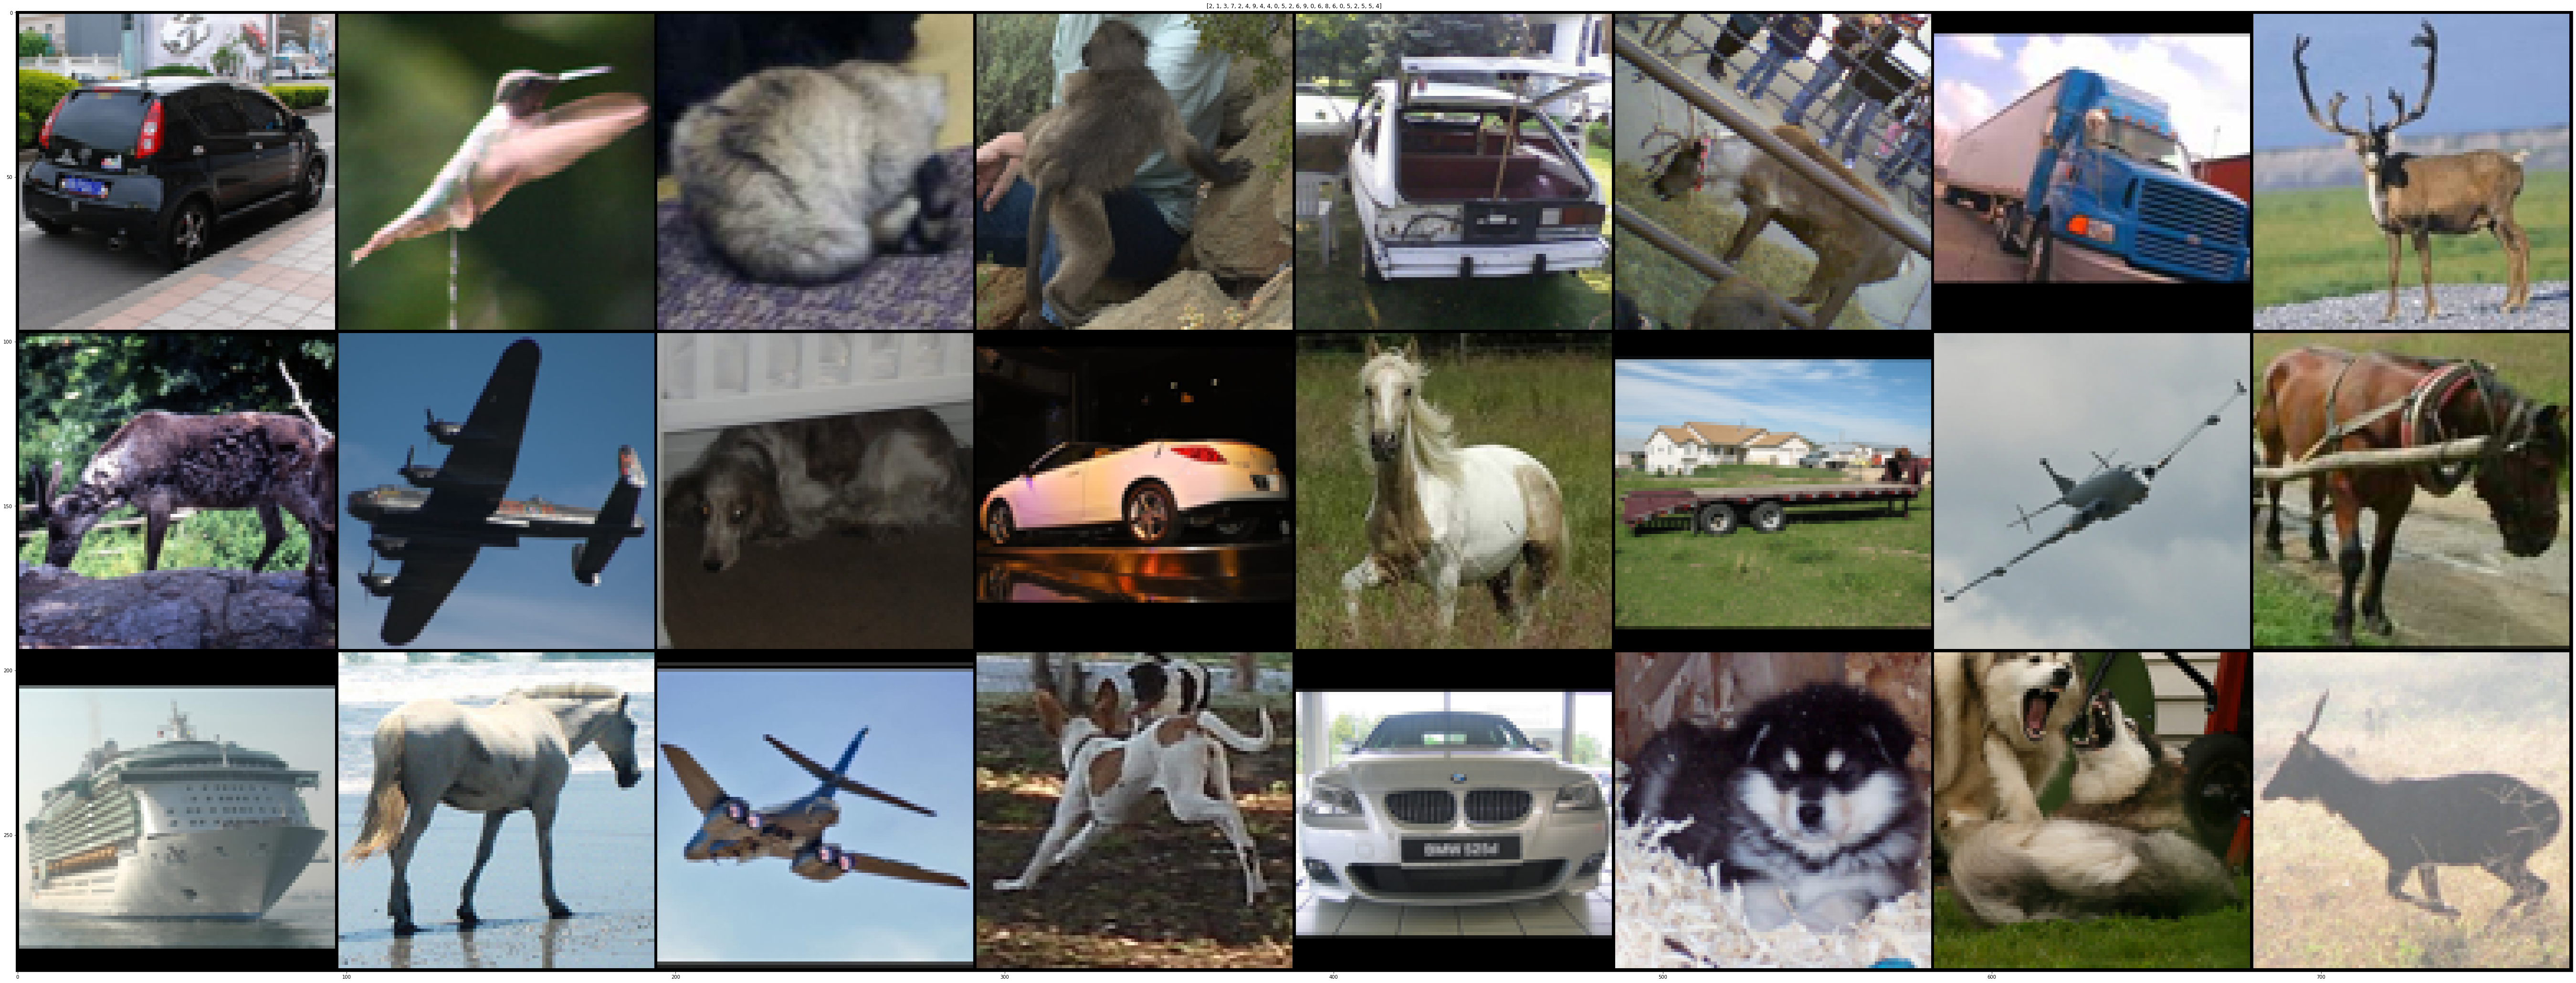

In [8]:
show_img(train_ds)

torch.Size([3, 292, 777])


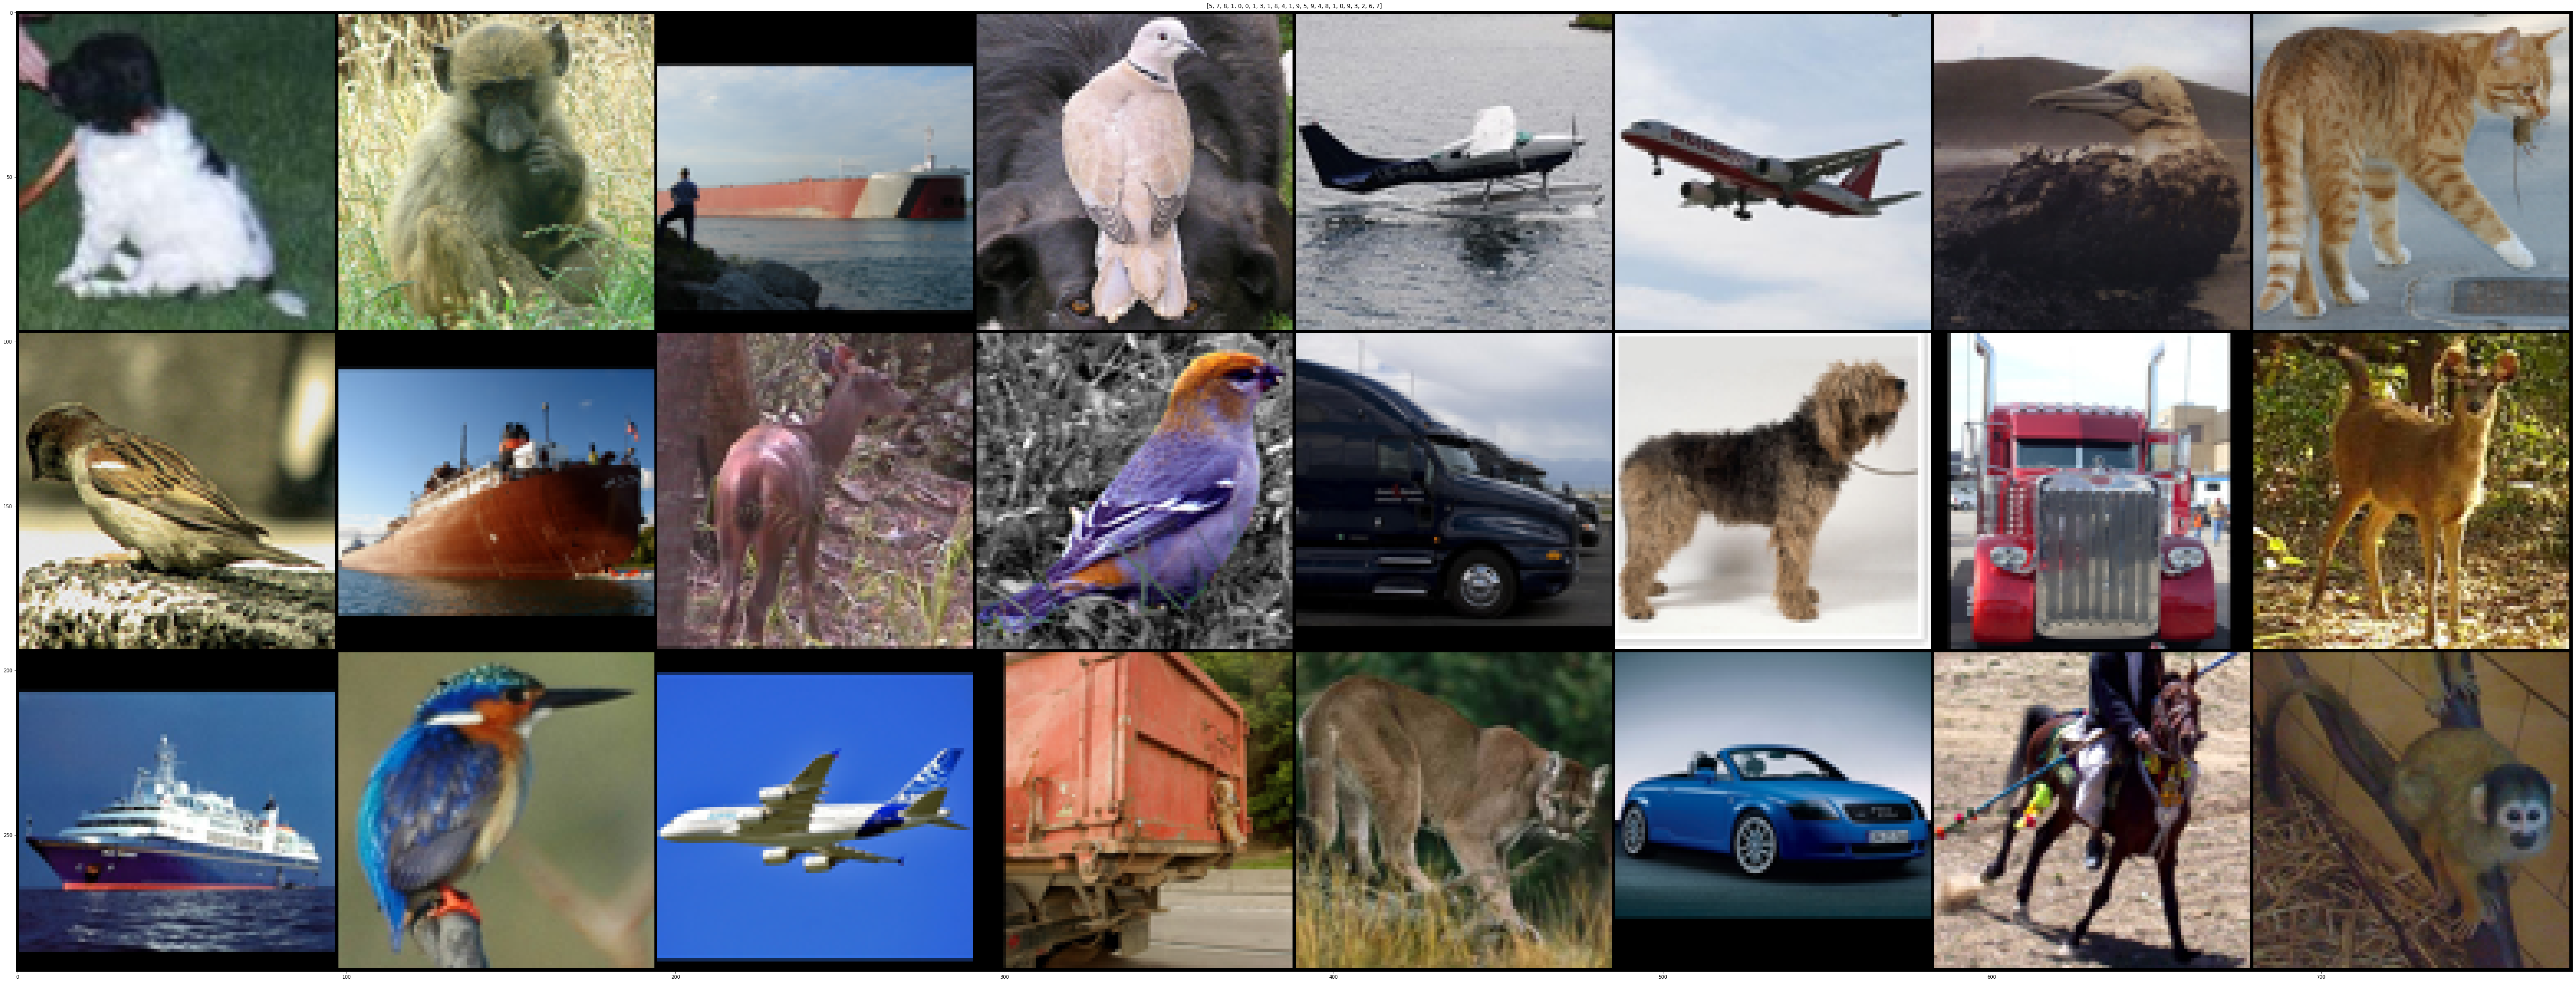

In [10]:
show_img(test_ds)

In [11]:
meanRGB = [np.mean(x.numpy(), axis=(1, 2)) for x, _ in train_ds]
stdRGB = [np.std(x.numpy(), axis=(1, 2)) for x, _ in train_ds]

meanR = np.mean([m[0] for m in meanRGB])
meanG = np.mean([m[1] for m in meanRGB])
meanB = np.mean([m[2] for m in meanRGB])

stdR = np.std([s[0] for s in stdRGB])
stdG = np.std([s[1] for s in stdRGB])
stdB = np.std([s[2] for s in stdRGB])

train_transformer = torchvision.transforms.Compose([
                  torchvision.transforms.RandomVerticalFlip(p=0.5),
                  torchvision.transforms.RandomHorizontalFlip(p=0.5),
                  torchvision.transforms.ToTensor(),
                  torchvision.transforms.Normalize([meanR,meanG,meanB], [stdR,stdG,stdB])
])

test_transformer = torchvision.transforms.Compose([
                   torchvision.transforms.ToTensor(),
                   torchvision.transforms.Normalize([meanR,meanG,meanB], [stdR,stdG,stdB])
])
train_ds.transform = train_transformer
test_ds.transform = test_transformer

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 292, 777])


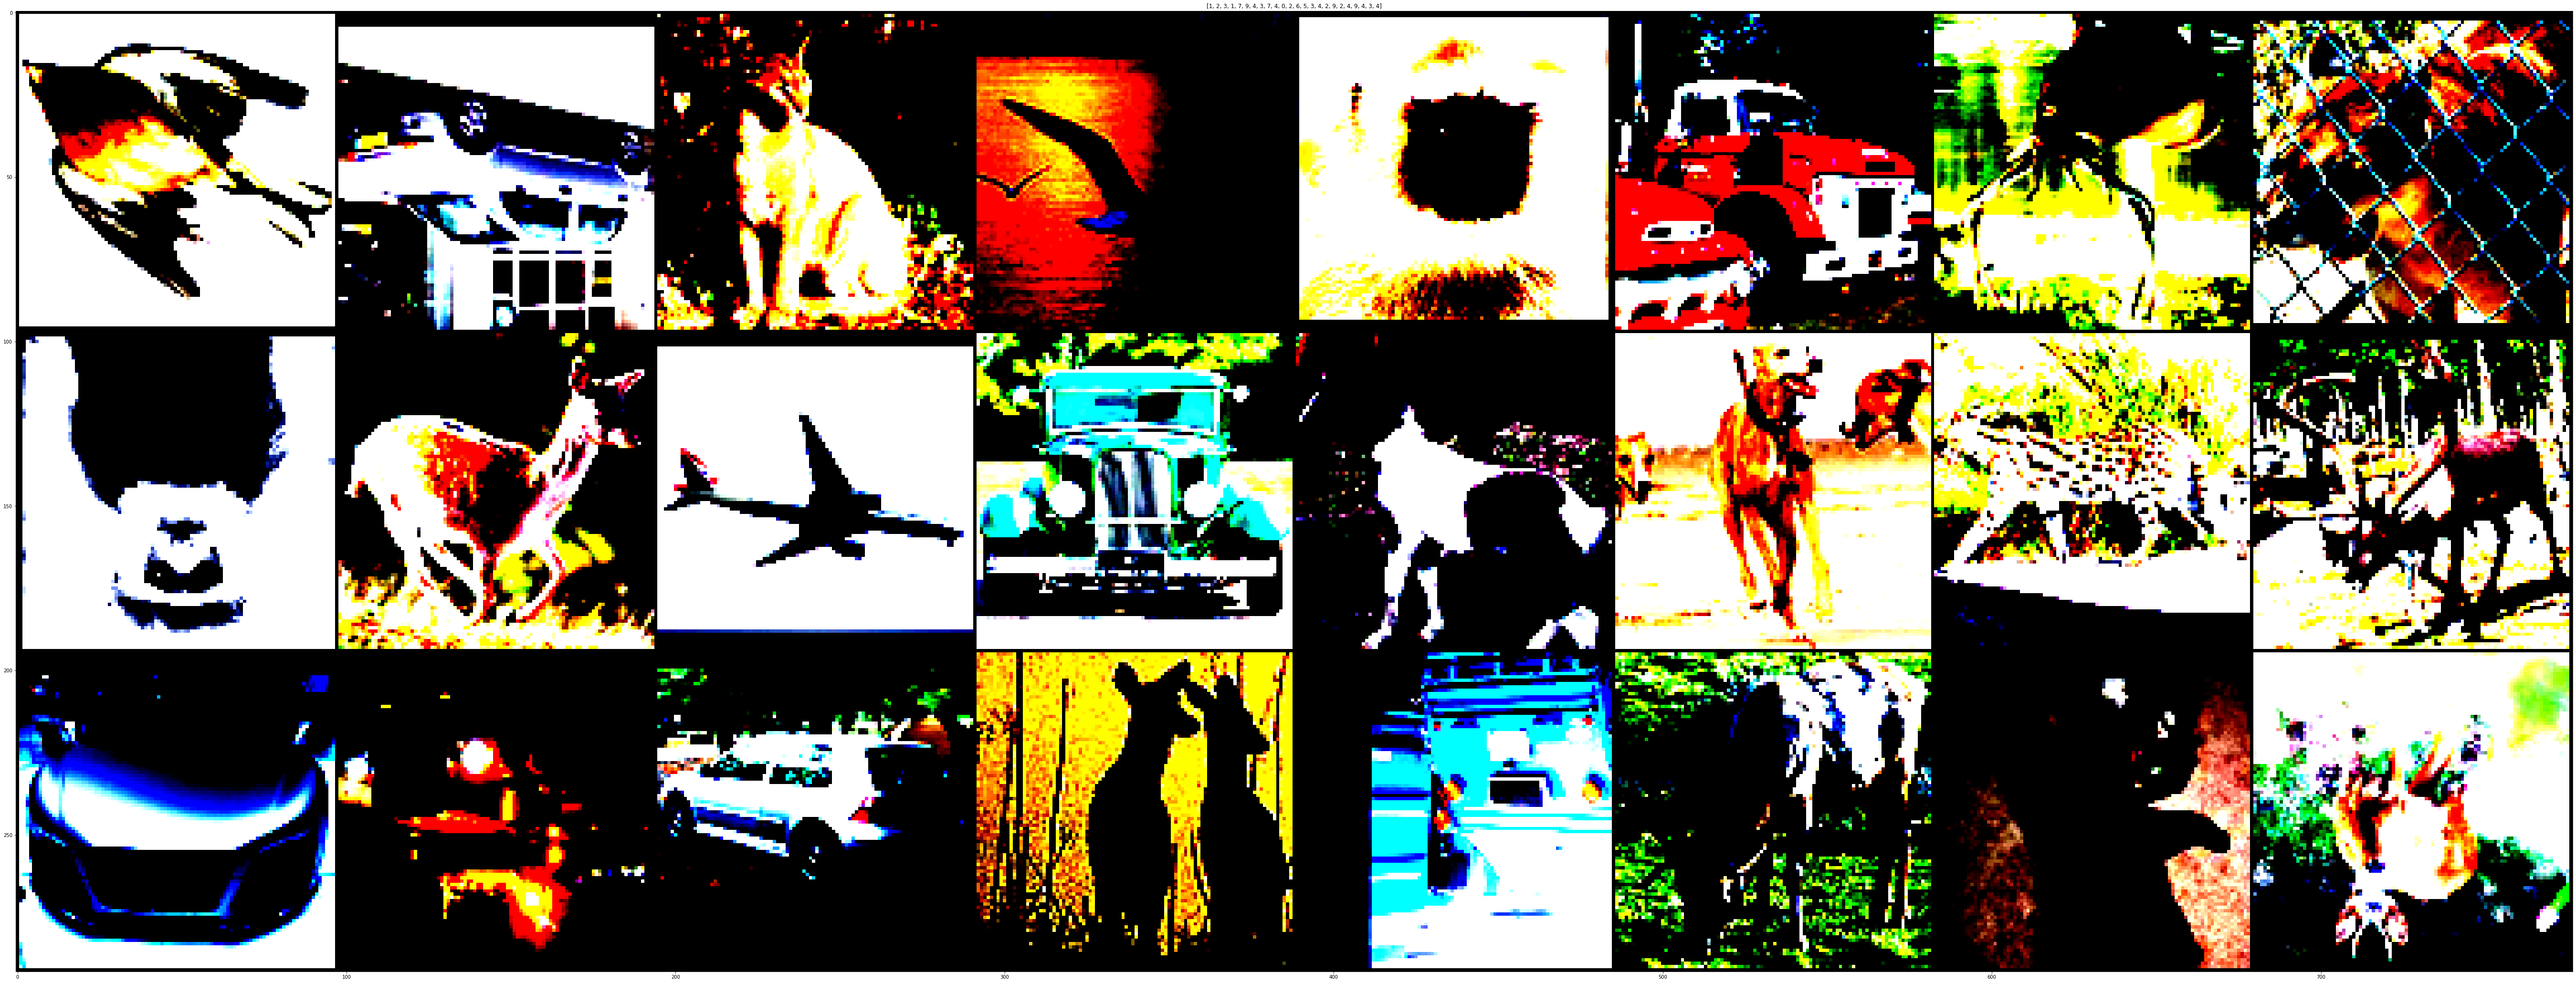

In [12]:
show_img(train_ds)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 292, 777])


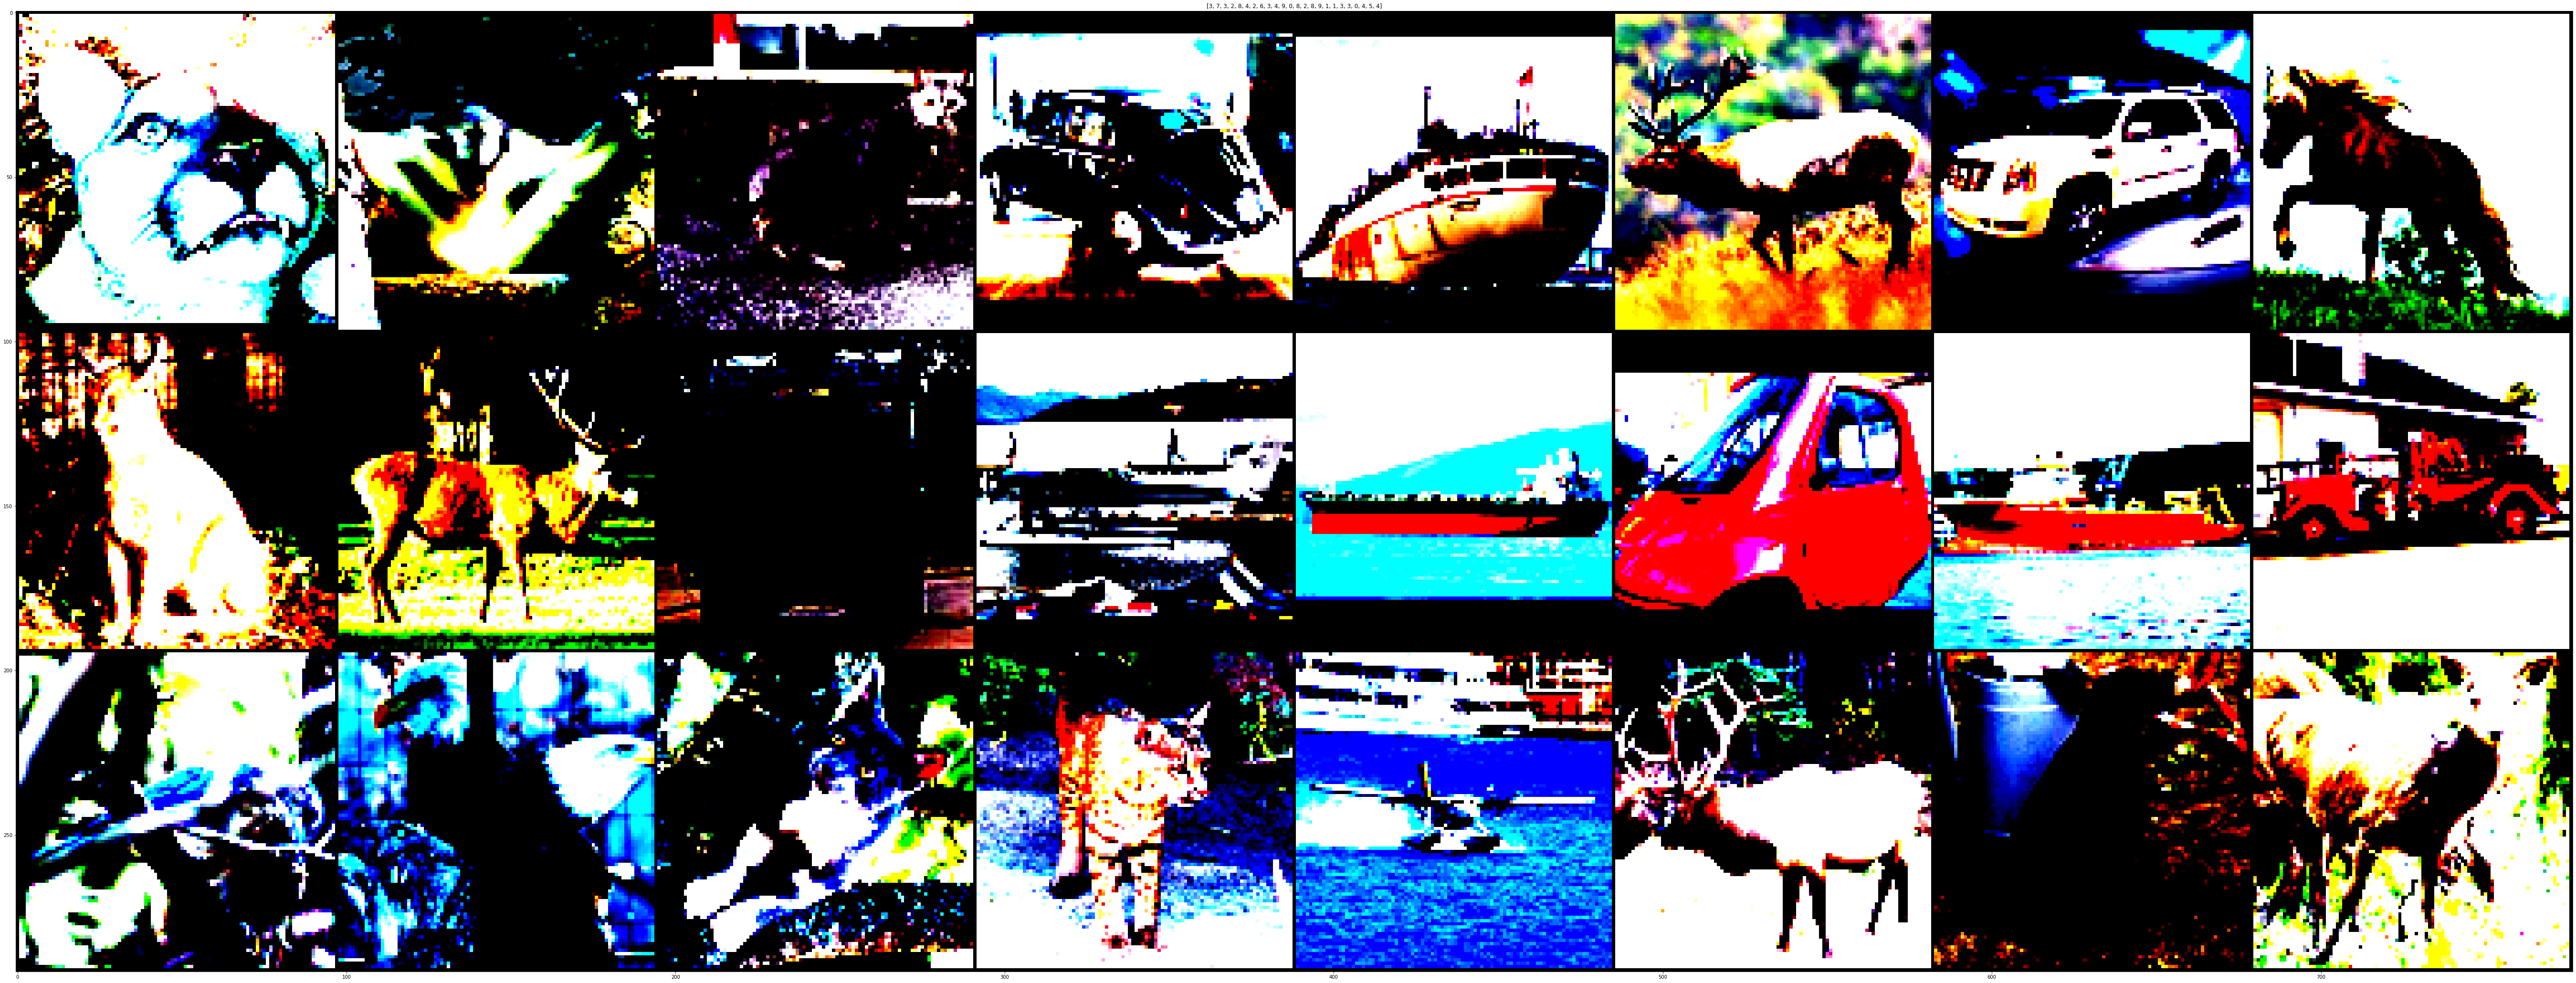

In [13]:
show_img(test_ds)